## Simulation of 11-3.9um brightness temperature difference

**Libraries used:**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd

**Retrieve GFS data:**

In [2]:
%%capture
gfs_file = 'model_data/gfs.t06z.pgrb2.0p25.f000'
gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

**Select region for simulation:**

In [3]:
latitude_north = 43
latitude_south = 36
longitude_west = -70
longitude_east = -60

region = gfs_ds.sel(latitude=slice(latitude_north, latitude_south), longitude=slice(360+longitude_west, 360+longitude_east))

In [4]:
region

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33, latitude: 29, longitude: 41)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 43.0 42.75 42.5 42.25 ... 36.5 36.25 36.0
  * longitude      (longitude) float64 290.0 290.2 290.5 ... 299.5 299.8 300.0
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
    q              (isobaricInhPa, latitude, longitude) float32 ...
    w              (isobaricInhPa, latitude, longitude) float32 ...
    wz             (isobaricInhPa, latitude, longitude) float32 ...
    u              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    absv           (isobaricInhPa, latitude, longitude) float32 ...
    o3mr           (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-06-03T14:35 GRIB to CDM+CF via cfgrib-0.9.1...

/var/folders/pd/x01_y6d52zj47w6_m5_h_8f80000gr/T/ipykernel_3956/2960025595.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


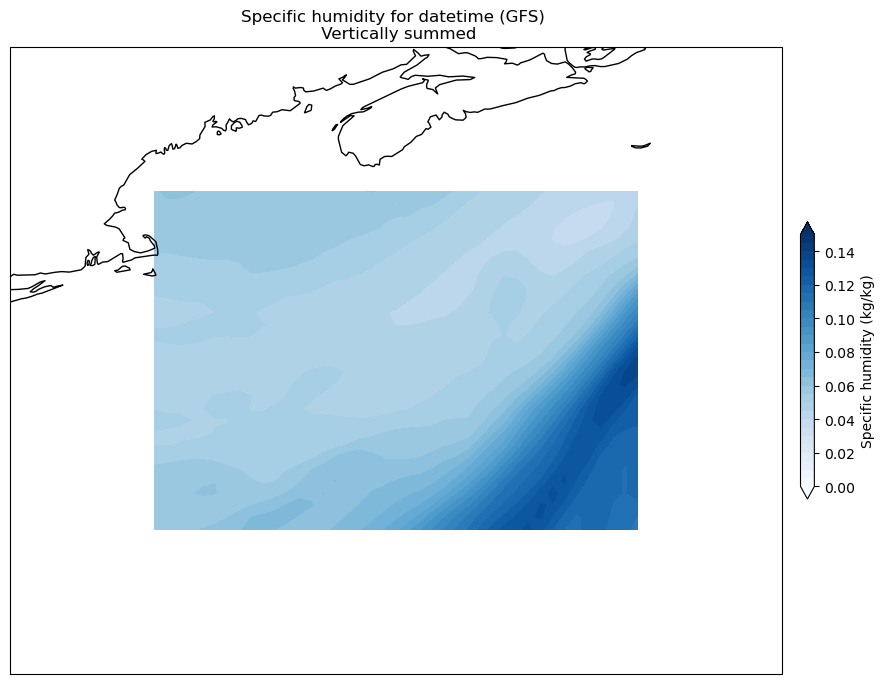

In [5]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Blues
levels = np.linspace(0, 0.15, 31)

c=ax.contourf(region.longitude, region.latitude, region.q.sum('isobaricInhPa'), cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('Specific humidity (kg/kg)')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Specific humidity for datetime (GFS) \n Vertically summed" )
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.show()

**Calculate the water vapor mass density for the region:**
* this is described in RadTran Miller presentation notes
* $r_g$ is the mixing ratio of water vapor, averaged between the layers ($p_1$ and $p_2$)
* mass density ($u$) is in kg m-2

$$
u(p_1, p_2) = \frac{1}{g}\int_{p_2}^{p_1} r_g dp
$$

In [6]:
g = 9.807 #m s-2
u = []

for i in range(len(region.isobaricInhPa.values)-1):
    p1 = region.isobaricInhPa.values[i]*100 #kg s-2 m-1
    p2 = region.isobaricInhPa.values[i+1]*100 #kg s-2 m-1
    dp = p1-p2

    r_g = (region.q.values[i] + region.q.values[i+1]) / 2 #kg kg-1

    u.append((1/g)*r_g*dp) #kg m-2

#--- u has dimensions of (hPa, lat, lon)


**Create an optical mass table:**
* The data is 3-dimensional (pressure, latitude, longitude), so the pandas dataframe is no longer the best method
* Instead, we build an x-array to store the optical mass values

In [7]:
optical_mass_da = xr.DataArray(u, dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})
temperature_da = xr.DataArray(region.t[0:-1], dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})


optical_mass_ds = xr.Dataset({'u': optical_mass_da,
                              'T': temperature_da})

In [8]:
optical_mass_ds

<xarray.Dataset>
Dimensions:  (hPa: 32, lat: 29, lon: 41)
Coordinates:
  * hPa      (hPa) float64 1e+03 975.0 950.0 925.0 900.0 ... 7.0 5.0 3.0 2.0
  * lat      (lat) float64 43.0 42.75 42.5 42.25 42.0 ... 36.75 36.5 36.25 36.0
  * lon      (lon) float64 290.0 290.2 290.5 290.8 ... 299.2 299.5 299.8 300.0
Data variables:
    u        (hPa, lat, lon) float32 2.033 2.046 2.067 ... 2.963e-05 2.968e-05
    T        (hPa, lat, lon) float32 288.9 289.1 289.1 ... 251.8 251.8 252.6

**Open the mass extinction look-up tables:**
* made in water_vapor_abs.ipynb

In [9]:
mass_ext_df_13 = pd.read_pickle('tables/mass_ext_band13')
mass_ext_df_14 = pd.read_pickle('tables/mass_ext_band14')
mass_ext_df_07 = pd.read_pickle('tables/mass_ext_band07')

**Create the optical thickness table:**
* using the mass extinction look-up tables (HITRAN-driven)
* using the optical mass table (GFS-driven)

*Currently stopped here. The 3d nature of the image makes the indexing more complicated.*

In [10]:
optical_thickness_07 = []
optical_thickness_13 = []
optical_thickness_14 = []

#pressure_profile = range(1000, 0, -100)
pressure_profile = optical_mass_ds.hPa[:21]

for pressure_value in pressure_profile:
    temperature_value = optical_mass_ds.sel(hPa=pressure_value)['T']
    optical_mass_value = optical_mass_ds.sel(hPa=pressure_value)['u']
    print(temperature_value)

    #---Find the nearest temperature and pressure indices
    nearest_temperature_07 = mass_ext_df_07.index[((mass_ext_df_07.index.values - temperature_value)**2).argmin()]
    nearest_pressure_07 = mass_ext_df_07.columns[((mass_ext_df_07.columns.values - pressure_value)**2).argmin()]

    #---Query the lookup table with the nearest indices
    mass_ext_value_07 = mass_ext_df_07.loc[nearest_temperature_07, nearest_pressure_07]

    print("Profile:", pressure_value, round(temperature_value, 1), "LUT:", round(nearest_pressure_07,1), nearest_temperature_07)
    #print("Optical mass:", round(optical_mass_value,1), "Mass ext:", round(mass_ext_value_13,1))

    optical_thickness_07.append(optical_mass_value*mass_ext_value_07)

<xarray.DataArray 'T' (lat: 29, lon: 41)>
array([[288.92136, 289.12137, 289.14136, ..., 290.35138, 290.55136,
        290.68137],
       [289.15137, 289.23135, 289.27136, ..., 290.70135, 290.90137,
        291.00137],
       [289.36136, 289.51135, 289.55136, ..., 290.92136, 291.10138,
        291.20135],
       ...,
       [295.41138, 295.53137, 295.70135, ..., 297.32138, 297.32138,
        297.13138],
       [295.64136, 295.62137, 295.57138, ..., 297.37137, 297.36136,
        297.15137],
       [295.61136, 295.56137, 295.55136, ..., 297.40137, 297.37137,
        297.19138]], dtype=float32)
Coordinates:
    hPa      float64 1e+03
  * lat      (lat) float64 43.0 42.75 42.5 42.25 42.0 ... 36.75 36.5 36.25 36.0
  * lon      (lon) float64 290.0 290.2 290.5 290.8 ... 299.2 299.5 299.8 300.0
Attributes: (12/29)
    GRIB_paramId:                             130
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:         

ValueError: operands could not be broadcast together with shapes (26,) (29,41) 

**Import the functions for expected radiance and brightness temperature:**
* created in expected_radiance.ipynb
* pip install ipynb, if needed

In [ ]:
from ipynb.fs.full.expected_radiance import blackbody_radiance, I_sfc, I_atm, brightness_temperature

In [ ]:
print("Brightness temperature total (11.2um): ", round(brightness_temperature(I_sfc(T_sfc, optical_thickness_df_14, 11.2e-6) + I_atm(optical_thickness_df_14, optical_mass_df, 11.2e-6), 11.2e-6)), " K")